#Traffic Signs Detection using YOLOv8

Fine tuned YOLOv8 for detecting small traffic signs in images and videos. The focus is on dataset preprocessing, challenges in small object detection, experiments with various model settings, and potential improvements.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install --quiet ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.1 MB/s eta 0:00:00


In [ ]:
import torch
from IPython.display import Image  # for displaying images
import os
import random
import shutil #for file and directory operations
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

# Dataset Description & Preprocessing:
## Road Sign Detection

This dataset contains **877 images** of **4 distinct classes** for the objective of road sign detection. Bounding box annotations are provided in the PASCAL VOC format.

### The classes are:
- **Traffic Light**
- **Stop**
- **Speed Limit**
- **Crosswalk**

Annotation format: Converted from Pascal VOC XML to YOLO format

In [ ]:
#format for annotations of images

!cat /content/drive/MyDrive/611/Road/annotations/road4.xml

##Preprocessing Steps
XML Parsing: Extracted bounding boxes and labels from XML annotations.

Dataset Converted to YOLO Format:
- Extracted class_id x_center y_center width height
- Ensured labels were stored correctly for training.

In [ ]:
# Function to get the data from XML Annotation

def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()

    # Initialise the info dict
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name
        if elem.tag == "filename":
            info_dict['filename'] = elem.text

        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))

            info_dict['image_size'] = tuple(image_size)

        # Get details of the bounding box
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text

                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)
            info_dict['bboxes'].append(bbox)

    return info_dict

In [ ]:
print(extract_info_from_xml('/content/drive/MyDrive/611/Road/annotations/road4.xml'))

{'bboxes': [{'class': 'trafficlight', 'xmin': 20, 'ymin': 109, 'xmax': 81, 'ymax': 237}, {'class': 'trafficlight', 'xmin': 116, 'ymin': 162, 'xmax': 163, 'ymax': 272}, {'class': 'trafficlight', 'xmin': 189, 'ymin': 189, 'xmax': 233, 'ymax': 295}], 'filename': 'road4.png', 'image_size': (267, 400, 3)}


In [ ]:
# Purpose : Generate text file of xml annotation file and store it into /kaggle/working/Road_Sign_Dataset path.

# Ensure the output directory exists
output_annotations_dir = "/content/working/Road_Sign_Dataset/annotations"
os.makedirs(output_annotations_dir, exist_ok=True)

# Define a mapping for class names to IDs
class_name_to_id_mapping = {
    "trafficlight": 0,
    "stop": 1,
    "speedlimit": 2,
    "crosswalk": 3,
    # Add other classes and their corresponding IDs
}

# Function to convert the info dict to the required YOLOv5 format and write it to the correct path
def convert_to_yolov5(info_dict):
    print_buffer = []

    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print(f"Invalid Class: {b['class']}. Must be one from {class_name_to_id_mapping.keys()}")
            continue  # Skip this annotation if the class is invalid

        # Transform the bbox coordinates as per the format required by YOLOv5
        b_center_x = (b["xmin"] + b["xmax"]) / 2
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])

        # Normalize the coordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]
        b_center_x /= image_w
        b_center_y /= image_h
        b_width    /= image_w
        b_height   /= image_h

        # Write the bbox details to the buffer
        print_buffer.append(f"{class_id} {b_center_x:.6f} {b_center_y:.6f} {b_width:.6f} {b_height:.6f}")

    # Ensure a unique filename for each annotation
    save_file_name = os.path.join(output_annotations_dir, info_dict["filename"].replace("png", "txt"))

    # Save the annotation to disk
    with open(save_file_name, "w") as f:
        f.write("\n".join(print_buffer))

# Function to extract info from XML file
def extract_info_from_xml(xml_file):
    tree = ET.parse(xml_file)  # Use XML parsing (e.g., xml.etree.ElementTree)
    root = tree.getroot()

    # Extract the image filename (this assumes the XML structure contains a 'filename' tag)
    image_filename = root.find('filename').text

    # Extract image size (assuming XML contains a 'size' tag with 'width' and 'height')
    image_width = int(root.find('size/width').text)
    image_height = int(root.find('size/height').text)
    image_channels = 3  # Assuming RGB image, change if necessary

    # Extract bounding boxes
    bboxes = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        bboxes.append({"class": class_name, "xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax})

    return {
        "filename": image_filename,
        "image_size": [image_width, image_height, image_channels],
        "bboxes": bboxes
    }

# Get the annotations from the input directory (adjust the path based on where the XML files are stored)
annotations_dir = '/content/drive/MyDrive/611/Road/annotations'
annotations = [os.path.join(annotations_dir, x) for x in os.listdir(annotations_dir) if x.endswith(".xml")]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)

# After conversion, the `.txt` files will be saved in /kaggle/working/Road_Sign_Dataset/annotations


100%|██████████| 877/877 [00:25<00:00, 34.95it/s] 


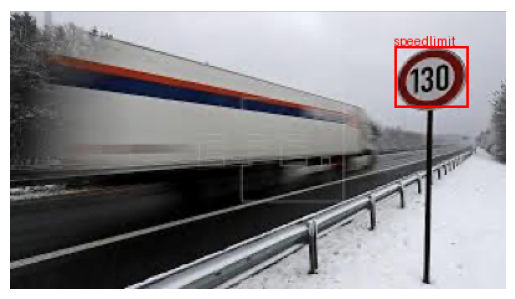

In [ ]:
# Class name to ID mapping
class_name_to_id_mapping = {
    "trafficlight": 0,
    "stop": 1,
    "speedlimit": 2,
    "crosswalk": 3
}

# Reverse mapping from class ID to class name
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

# Function to plot bounding boxes on the image
def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    # Transform the annotation coordinates from relative to absolute
    transformed_annotations = np.copy(annotations)
    transformed_annotations[:, [1, 3]] = annotations[:, [1, 3]] * w  # Normalize width
    transformed_annotations[:, [2, 4]] = annotations[:, [2, 4]] * h  # Normalize height

    transformed_annotations[:, 1] = transformed_annotations[:, 1] - (transformed_annotations[:, 3] / 2)
    transformed_annotations[:, 2] = transformed_annotations[:, 2] - (transformed_annotations[:, 4] / 2)
    transformed_annotations[:, 3] = transformed_annotations[:, 1] + transformed_annotations[:, 3]
    transformed_annotations[:, 4] = transformed_annotations[:, 2] + transformed_annotations[:, 4]

    # Plot each bounding box with its class label
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0, y0), (x1, y1)), outline="red", width=2)

        # Draw the class name text above the bounding box
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[int(obj_cls)], fill="red")

    # Show the image with bounding boxes
    plt.imshow(np.array(image))
    plt.axis('off')
    plt.show()

# Path to annotations and images directories
annotation_dir = '/content/working/Road_Sign_Dataset/annotations'
image_dir = '/content/drive/MyDrive/611/Road/images'

# Target specific image and its corresponding annotation file
image_file = 'road116.png'
annotation_file = image_file.replace("png", "txt")

# Check if the annotation file exists
annotation_file_path = os.path.join(annotation_dir, annotation_file)
assert os.path.exists(annotation_file_path), f"Annotation file {annotation_file_path} does not exist!"

# Read the annotation file
with open(annotation_file_path, 'r') as file:
    # Read all lines and split by spaces to form a 2D array
    annotation_list = file.read().splitlines()  # Read all lines
    annotation_list = [line.split(" ") for line in annotation_list]  # Split by space
    annotation_list = [[float(y) for y in line] for line in annotation_list]  # Convert to float

# Get the corresponding image file path
image_file_path = os.path.join(image_dir, image_file)

# Load the image
image = Image.open(image_file_path)

# Plot the bounding boxes on the image
plot_bounding_box(image, annotation_list)


In [ ]:
# Delete One extra file which generate first time

# Define the directories for images and annotations
image_dir = '/content/drive/MyDrive/611/Road/images'
annotation_dir = '/content/working/Road_Sign_Dataset/annotations'

# Get the list of image filenames without extensions (e.g., "road0")
image_files = set(os.path.splitext(f)[0] for f in os.listdir(image_dir))
# Get the list of annotation filenames without extensions (e.g., "road0")
annotation_files = set(os.path.splitext(f)[0] for f in os.listdir(annotation_dir) if f.endswith('.txt'))

# Find the extra annotation files (those that don't have a corresponding image)
extra_annotations = annotation_files - image_files

# If there's any extra annotation file, print and delete it
if extra_annotations:
    print(f"Extra annotation file(s) found: {extra_annotations}")
    for extra_file in extra_annotations:
        extra_file_path = os.path.join(annotation_dir, extra_file + '.txt')
        os.remove(extra_file_path)
        print(f"Deleted extra annotation file: {extra_file_path}")
else:
    print("No extra annotation files found.")

# Verify the changes
annotations = [f for f in os.listdir(annotation_dir) if f.endswith('.txt')]
print(f"Remaining annotation files: {annotations}")


No extra annotation files found.
Remaining annotation files: ['road121.txt', 'road402.txt', 'road278.txt', 'road141.txt', 'road102.txt', 'road809.txt', 'road335.txt', 'road593.txt', 'road641.txt', 'road31.txt', 'road458.txt', 'road454.txt', 'road14.txt', 'road758.txt', 'road40.txt', 'road780.txt', 'road471.txt', 'road176.txt', 'road451.txt', 'road277.txt', 'road221.txt', 'road852.txt', 'road829.txt', 'road70.txt', 'road72.txt', 'road494.txt', 'road840.txt', 'road722.txt', 'road665.txt', 'road747.txt', 'road212.txt', 'road513.txt', 'road71.txt', 'road618.txt', 'road256.txt', 'road554.txt', 'road177.txt', 'road351.txt', 'road658.txt', 'road646.txt', 'road634.txt', 'road48.txt', 'road270.txt', 'road319.txt', 'road509.txt', 'road474.txt', 'road628.txt', 'road709.txt', 'road551.txt', 'road286.txt', 'road527.txt', 'road366.txt', 'road820.txt', 'road150.txt', 'road522.txt', 'road533.txt', 'road516.txt', 'road654.txt', 'road29.txt', 'road651.txt', 'road194.txt', 'road88.txt', 'road452.txt', 'r

In [ ]:
# Spliting the data into train ,test and validation part

# Read images and annotations
images = [os.path.join('/content/drive/MyDrive/611/Road/images', x) for x in os.listdir('/content/drive/MyDrive/611/Road/images')]
annotations = [os.path.join('/content/working/Road_Sign_Dataset/annotations', x) for x in os.listdir('/content/working/Road_Sign_Dataset/annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [ ]:
# Make directories to store the train , test and validation images with their correspoinding labels

[os.makedirs(f'/content/working/{folder}', exist_ok=True) for folder in ['images/train', 'images/val', 'images/test', 'annotations/train', 'annotations/val', 'annotations/test']]

[None, None, None, None, None, None]

In [ ]:
# Moving the images into that directories

# Utility function to copy images and annotations
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        shutil.copy(f, f'/content/working/{destination_folder}')  # Copy instead of move

# Define and sort paths for images and annotations
images = [os.path.join('/content/drive/MyDrive/611/Road/images', x) for x in os.listdir('/content/drive/MyDrive/611/Road/images')]
annotations = [os.path.join('/content/working/Road_Sign_Dataset/annotations', x) for x in os.listdir('/content/working/Road_Sign_Dataset/annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split dataset into train-valid-test splits
from sklearn.model_selection import train_test_split
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size=0.2, random_state=1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size=0.5, random_state=1)

# Create necessary directories for splits
os.makedirs('/content/working/images/train', exist_ok=True)
os.makedirs('/content/working/images/val', exist_ok=True)
os.makedirs('/content/working/images/test', exist_ok=True)
os.makedirs('/content/working/annotations/train', exist_ok=True)
os.makedirs('/content/working/annotations/val', exist_ok=True)
os.makedirs('/content/working/annotations/test', exist_ok=True)

# Move the splits into their respective folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val')
move_files_to_folder(test_images, 'images/test')
move_files_to_folder(train_annotations, 'annotations/train')
move_files_to_folder(val_annotations, 'annotations/val')
move_files_to_folder(test_annotations, 'annotations/test')

In [ ]:
# to rename annotations to labels
# Define the source and destination directories
source_dir = '/content/working/annotations'
destination_dir = '/content/working/labels'

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Move the contents of the source directory to the destination directory
for file_name in os.listdir(source_dir):
    source_file = os.path.join(source_dir, file_name)
    destination_file = os.path.join(destination_dir, file_name)

    # If it's a file, copy it; if it's a directory, move it (if needed)
    if os.path.isfile(source_file):
        shutil.move(source_file, destination_file)
    elif os.path.isdir(source_file):
        shutil.move(source_file, destination_file)


In [ ]:
# Check if the directory is empty
if not os.listdir(source_dir):  # if the directory is empty
    os.rmdir(source_dir)  # remove the empty directory

In [ ]:
# Function to count the total files in a directory including subdirectories
def count_files_in_directory(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

# Count files in the 'images' and 'labels' directories
images_count = count_files_in_directory('/content/working/images')
labels_count = count_files_in_directory('/content/working/labels')

# Print the results
print(f"Total files in '/content/working/images': {images_count}")
print(f"Total files in '/content/working/labels': {labels_count}")

Total files in '/content/working/images': 877
Total files in '/content/working/labels': 877


##Creating yaml file

In [ ]:
# Define the file path
file_path = '/content/working/yolov8/data/road_sign_data.yaml'

# Define the content to be written in the YAML file
yaml_content = """
train: /content/working/images/train/
val: /content/working/images/val/
test: /content/working/images/test/

# number of classes
nc: 4

# class names
names: ["trafficlight", "stop", "speedlimit", "crosswalk"]
"""

# Create the directory if it doesn't exist
os.makedirs('/content/working/yolov8/data', exist_ok=True)

# Write the content to the file
with open(file_path, 'w') as file:
    file.write(yaml_content)


In [ ]:
# show the content of that file
# Define the file path
file_path = '/content/working/yolov8/data/road_sign_data.yaml'

# Open the file and print its content
with open(file_path, 'r') as file:
    content = file.read()

# Print the content of the file
print(content)


train: /content/working/images/train/
val: /content/working/images/val/
test: /content/working/images/test/

# number of classes
nc: 4

# class names
names: ["trafficlight", "stop", "speedlimit", "crosswalk"]



# Challenges in Detecting Small Objects  

🔹 **Low Pixel Coverage:** Traffic signs are small in images, making them harder to detect.  
🔹 **Imbalanced Data:** Some classes (e.g., stop signs) were overrepresented.  
🔹 **Poor Bounding Box Placement:** YOLO’s default anchors did not fit small objects well.  
🔹 **Blurry Images:** Motion blur from road images affected performance.  


In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt") # Load pre-trained YOLO model

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 114MB/s]


In [ ]:
results = model.train(
    data = '/content/working/yolov8/data/road_sign_data.yaml',
    epochs = 40,
    imgsz = 1280,
    batch = 16,
)

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/working/yolov8/data/road_sign_data.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

100%|██████████| 755k/755k [00:00<00:00, 21.2MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 98.0MB/s]


AMP: checks passed ✅


train: Scanning /content/working/labels/train... 701 images, 0 backgrounds, 0 corrupt: 100%|██████████| 701/701 [00:00<00:00, 1031.89it/s]

train: New cache created: /content/working/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/working/labels/val... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<00:00, 468.54it/s]

val: New cache created: /content/working/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      7.96G     0.7929       3.89      1.062         28       1280: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]

                   all         88        132    0.00542      0.911       0.65      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      9.73G     0.7864      2.717      1.047         39       1280: 100%|██████████| 44/44 [00:45<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all         88        132      0.694      0.502      0.557      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      9.75G     0.7923      2.388       1.05         32       1280: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all         88        132      0.856      0.664      0.784      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      9.76G     0.7825      2.047      1.042         56       1280: 100%|██████████| 44/44 [00:48<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all         88        132      0.867      0.698      0.802      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      9.78G     0.7378      1.664      1.031         35       1280: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

                   all         88        132      0.877      0.837       0.89      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40       9.8G     0.7635      1.409       1.01         33       1280: 100%|██████████| 44/44 [00:46<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all         88        132      0.829      0.839      0.865      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      9.81G     0.7456      1.284      1.014         29       1280: 100%|██████████| 44/44 [00:43<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all         88        132      0.953      0.806      0.874      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      9.83G     0.7246      1.209      1.017         31       1280: 100%|██████████| 44/44 [00:45<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         88        132      0.937      0.801      0.872      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      9.85G     0.7227       1.05      1.007         34       1280: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all         88        132      0.907      0.844      0.896      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      9.87G     0.7135     0.9437     0.9974         34       1280: 100%|██████████| 44/44 [00:46<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         88        132      0.884      0.872      0.927      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      9.88G     0.6981     0.8259     0.9807         23       1280: 100%|██████████| 44/44 [00:47<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         88        132      0.892      0.899      0.906      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40       9.9G     0.6753     0.8011     0.9878         32       1280: 100%|██████████| 44/44 [00:46<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all         88        132      0.965      0.892      0.913      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      9.92G      0.652     0.7404     0.9714         50       1280: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

                   all         88        132      0.882      0.855      0.906      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      9.93G     0.6392     0.6812     0.9665         31       1280: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all         88        132      0.898      0.824       0.87      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      9.95G     0.6433     0.6568     0.9571         36       1280: 100%|██████████| 44/44 [00:47<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         88        132      0.904      0.925      0.931      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      9.97G     0.6231     0.6381     0.9486         23       1280: 100%|██████████| 44/44 [00:47<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

                   all         88        132      0.969       0.88      0.918      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      9.99G     0.6289     0.6238     0.9609         26       1280: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

                   all         88        132      0.965      0.872      0.921      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40        10G      0.611      0.573     0.9464         27       1280: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all         88        132      0.967      0.885      0.939      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40        10G     0.6215     0.5705     0.9529         24       1280: 100%|██████████| 44/44 [00:51<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all         88        132      0.984      0.843      0.905       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40        10G     0.6151     0.5427     0.9432         34       1280: 100%|██████████| 44/44 [00:47<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         88        132      0.933      0.875      0.924      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      10.1G     0.6161     0.5302     0.9439         36       1280: 100%|██████████| 44/44 [00:47<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]

                   all         88        132      0.962      0.887       0.94      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      10.1G     0.6053     0.5076     0.9339         18       1280: 100%|██████████| 44/44 [00:49<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         88        132      0.949      0.934      0.955       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      10.1G     0.5794     0.4877     0.9239         40       1280: 100%|██████████| 44/44 [00:50<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         88        132      0.923      0.923      0.927      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      10.1G     0.6069     0.4745     0.9293         31       1280: 100%|██████████| 44/44 [00:51<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         88        132      0.954      0.902      0.936      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      10.1G     0.5853     0.4604     0.9307         39       1280: 100%|██████████| 44/44 [00:51<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         88        132      0.954      0.896      0.928      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      10.1G     0.5694     0.4432     0.9243         38       1280: 100%|██████████| 44/44 [00:45<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         88        132      0.967      0.882      0.924      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      10.2G     0.5954     0.4592     0.9363         29       1280: 100%|██████████| 44/44 [00:51<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         88        132      0.949      0.879      0.916      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      10.2G     0.5677     0.4346     0.9166         36       1280: 100%|██████████| 44/44 [00:52<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         88        132      0.919      0.919      0.938      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      10.2G     0.5531     0.4182     0.9121         32       1280: 100%|██████████| 44/44 [00:55<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         88        132      0.938      0.922      0.936      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      10.2G     0.5373     0.4171     0.9027         27       1280: 100%|██████████| 44/44 [00:51<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

                   all         88        132      0.959      0.908      0.932       0.76


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      10.2G     0.5382     0.4018     0.8831         19       1280: 100%|██████████| 44/44 [00:44<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all         88        132      0.952      0.909      0.926      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      10.2G     0.5356     0.3941     0.8983         14       1280: 100%|██████████| 44/44 [00:41<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         88        132      0.978      0.898      0.953      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      10.3G     0.5159     0.3755     0.8834         19       1280: 100%|██████████| 44/44 [00:45<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         88        132      0.986      0.903      0.945      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      10.3G     0.5207     0.3675     0.8825         16       1280: 100%|██████████| 44/44 [00:42<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         88        132      0.968      0.909       0.93      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      10.3G     0.4919     0.3522     0.8775         16       1280: 100%|██████████| 44/44 [00:42<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all         88        132      0.974      0.913      0.945      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      10.3G     0.5013     0.3408     0.8697         30       1280: 100%|██████████| 44/44 [00:44<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         88        132      0.982      0.901      0.949      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      10.3G     0.4998     0.3508     0.8726         19       1280: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]

                   all         88        132      0.967      0.922      0.944      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      10.3G     0.4997     0.3369     0.8771         16       1280: 100%|██████████| 44/44 [00:44<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         88        132      0.968      0.922      0.943      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      10.4G     0.4914     0.3353      0.863         14       1280: 100%|██████████| 44/44 [00:46<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         88        132      0.968      0.922      0.947      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      10.4G     0.4868     0.3243     0.8578         16       1280: 100%|██████████| 44/44 [00:43<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         88        132      0.966      0.906      0.949      0.792



40 epochs completed in 0.564 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


                   all         88        132      0.968      0.921      0.947      0.795
          trafficlight         10         19      0.918      0.789      0.883      0.546
                  stop         10         10      0.965        0.9      0.914      0.876
            speedlimit         69         81      0.988          1      0.995      0.923
             crosswalk         16         22          1      0.995      0.995      0.836
Speed: 0.7ms preprocess, 8.2ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/detect/train


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!zip -r runs.zip runs

In [ ]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt source='./working/images/train/road0.png'

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 /content/working/images/train/road0.png: 1280x864 1 trafficlight, 33.5ms
Speed: 13.4ms preprocess, 33.5ms inference, 291.3ms postprocess per image at shape (1, 3, 1280, 864)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


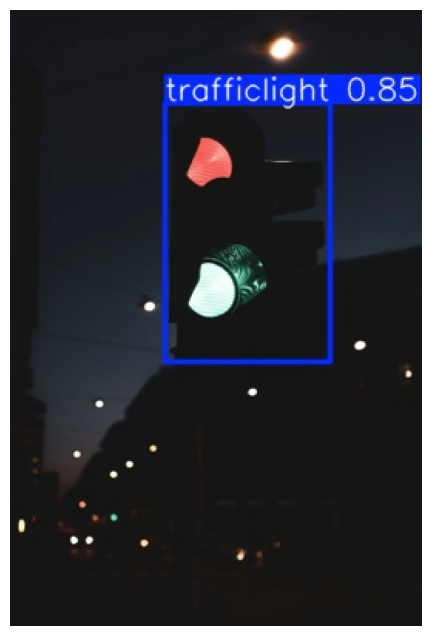

In [ ]:
test_image = plt.imread('/content/runs/detect/predict/road0.jpg')

plt.figure(figsize=(8, 8))
plt.imshow(test_image)
plt.axis('off')
plt.show()

In [ ]:
!zip -r working.zip working

In [ ]:
from ultralytics import YOLO
model_with_Data_Augmentation=YOLO("yolov8n.pt")

##Experimentation with YOLO Configurations

To improve small object detection, multiple settings were tested:

###Data Augmentation:
Applied scaling, flipping, blurring, and cropping.

Effect: Improved generalization and recall for small objects.



In [ ]:
results = model_with_Data_Augmentation.train(
    data = '/content/working/yolov8/data/road_sign_data.yaml',
    epochs = 40,
    imgsz = 1280,
    batch = 16,
    augment=True
)

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/working/yolov8/data/road_sign_data.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

train: Scanning /content/working/labels/train.cache... 701 images, 0 backgrounds, 0 corrupt: 100%|██████████| 701/701 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/working/labels/val.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40       7.9G     0.7929       3.89      1.062         28       1280: 100%|██████████| 44/44 [00:46<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.47s/it]

                   all         88        132    0.00542      0.911       0.65      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      9.67G     0.7864      2.717      1.047         39       1280: 100%|██████████| 44/44 [00:43<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all         88        132      0.694      0.502      0.557      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      9.69G     0.7923      2.388       1.05         32       1280: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all         88        132      0.856      0.664      0.784      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      9.71G     0.7825      2.047      1.042         56       1280: 100%|██████████| 44/44 [00:42<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

                   all         88        132      0.867      0.698      0.802      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      9.71G     0.7378      1.664      1.031         35       1280: 100%|██████████| 44/44 [00:43<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

                   all         88        132      0.877      0.837       0.89      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      9.71G     0.7635      1.409       1.01         33       1280: 100%|██████████| 44/44 [00:43<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all         88        132      0.829      0.839      0.865      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      9.71G     0.7456      1.284      1.014         29       1280: 100%|██████████| 44/44 [00:42<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

                   all         88        132      0.953      0.806      0.874      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      9.71G     0.7246      1.209      1.017         31       1280: 100%|██████████| 44/44 [00:43<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]

                   all         88        132      0.937      0.801      0.872      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      9.72G     0.7227       1.05      1.007         34       1280: 100%|██████████| 44/44 [00:43<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

                   all         88        132      0.907      0.844      0.896      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      9.72G     0.7135     0.9437     0.9974         34       1280: 100%|██████████| 44/44 [00:43<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         88        132      0.884      0.872      0.927      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      9.72G     0.6981     0.8259     0.9807         23       1280: 100%|██████████| 44/44 [00:42<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         88        132      0.892      0.899      0.906      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      9.72G     0.6753     0.8011     0.9878         32       1280: 100%|██████████| 44/44 [00:44<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all         88        132      0.965      0.892      0.913      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      9.74G      0.652     0.7404     0.9714         50       1280: 100%|██████████| 44/44 [00:42<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         88        132      0.882      0.855      0.906      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      9.75G     0.6392     0.6812     0.9665         31       1280: 100%|██████████| 44/44 [00:43<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         88        132      0.898      0.824       0.87      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      9.75G     0.6433     0.6568     0.9571         36       1280: 100%|██████████| 44/44 [00:43<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         88        132      0.904      0.925      0.931      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      9.75G     0.6231     0.6381     0.9486         23       1280: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         88        132      0.969       0.88      0.918      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      9.76G     0.6289     0.6238     0.9609         26       1280: 100%|██████████| 44/44 [00:44<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all         88        132      0.965      0.872      0.921      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      9.77G      0.611      0.573     0.9464         27       1280: 100%|██████████| 44/44 [00:43<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

                   all         88        132      0.967      0.885      0.939      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      9.77G     0.6215     0.5705     0.9529         24       1280: 100%|██████████| 44/44 [00:42<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all         88        132      0.984      0.843      0.905       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      9.77G     0.6151     0.5427     0.9432         34       1280: 100%|██████████| 44/44 [00:44<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         88        132      0.933      0.875      0.924      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      9.77G     0.6161     0.5302     0.9439         36       1280: 100%|██████████| 44/44 [00:43<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all         88        132      0.962      0.887       0.94      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      9.77G     0.6053     0.5076     0.9339         18       1280: 100%|██████████| 44/44 [00:42<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         88        132      0.949      0.934      0.955       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      9.77G     0.5794     0.4877     0.9239         40       1280: 100%|██████████| 44/44 [00:44<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         88        132      0.923      0.923      0.927      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      9.77G     0.6069     0.4745     0.9293         31       1280: 100%|██████████| 44/44 [00:43<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         88        132      0.954      0.902      0.936      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      9.77G     0.5853     0.4604     0.9307         39       1280: 100%|██████████| 44/44 [00:53<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all         88        132      0.954      0.896      0.928      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      9.77G     0.5694     0.4432     0.9243         38       1280: 100%|██████████| 44/44 [00:55<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

                   all         88        132      0.967      0.882      0.924      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      9.77G     0.5954     0.4592     0.9363         29       1280: 100%|██████████| 44/44 [00:46<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all         88        132      0.949      0.879      0.916      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      9.77G     0.5677     0.4346     0.9166         36       1280: 100%|██████████| 44/44 [00:43<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all         88        132      0.919      0.919      0.938      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      9.77G     0.5531     0.4182     0.9121         32       1280: 100%|██████████| 44/44 [00:43<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         88        132      0.938      0.922      0.936      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      9.77G     0.5373     0.4171     0.9027         27       1280: 100%|██████████| 44/44 [00:44<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         88        132      0.959      0.908      0.932       0.76


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      9.77G     0.5382     0.4018     0.8831         19       1280: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         88        132      0.952      0.909      0.926      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      9.77G     0.5356     0.3941     0.8983         14       1280: 100%|██████████| 44/44 [00:41<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

                   all         88        132      0.978      0.898      0.953      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      9.77G     0.5159     0.3755     0.8834         19       1280: 100%|██████████| 44/44 [00:41<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         88        132      0.986      0.903      0.945      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      9.77G     0.5207     0.3675     0.8825         16       1280: 100%|██████████| 44/44 [00:42<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         88        132      0.968      0.909       0.93      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      9.77G     0.4919     0.3522     0.8775         16       1280: 100%|██████████| 44/44 [00:41<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         88        132      0.974      0.913      0.945      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      9.77G     0.5013     0.3408     0.8697         30       1280: 100%|██████████| 44/44 [00:41<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all         88        132      0.982      0.901      0.949      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      9.77G     0.4998     0.3508     0.8726         19       1280: 100%|██████████| 44/44 [00:41<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         88        132      0.967      0.922      0.944      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      9.77G     0.4997     0.3369     0.8771         16       1280: 100%|██████████| 44/44 [00:41<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         88        132      0.968      0.922      0.943      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      9.77G     0.4914     0.3353      0.863         14       1280: 100%|██████████| 44/44 [00:42<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]

                   all         88        132      0.968      0.922      0.947      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      9.77G     0.4868     0.3243     0.8578         16       1280: 100%|██████████| 44/44 [00:41<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all         88        132      0.966      0.906      0.949      0.792



40 epochs completed in 0.527 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.4MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.4MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  2.00s/it]


                   all         88        132      0.956      0.918      0.948      0.794
          trafficlight         10         19      0.867      0.789      0.882      0.557
                  stop         10         10      0.965        0.9      0.922      0.883
            speedlimit         69         81      0.991          1      0.995      0.913
             crosswalk         16         22          1      0.983      0.995      0.822
Speed: 0.8ms preprocess, 46.1ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/train4


In [ ]:
!zip -r runs.zip runs

In [ ]:
!yolo task=detect mode=predict model=/content/runs/detect/train4/weights/best.pt source='./working/images/train/road1.png'

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 /content/working/images/train/road1.png: 928x1280 1 trafficlight, 47.4ms
Speed: 13.6ms preprocess, 47.4ms inference, 196.8ms postprocess per image at shape (1, 3, 928, 1280)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


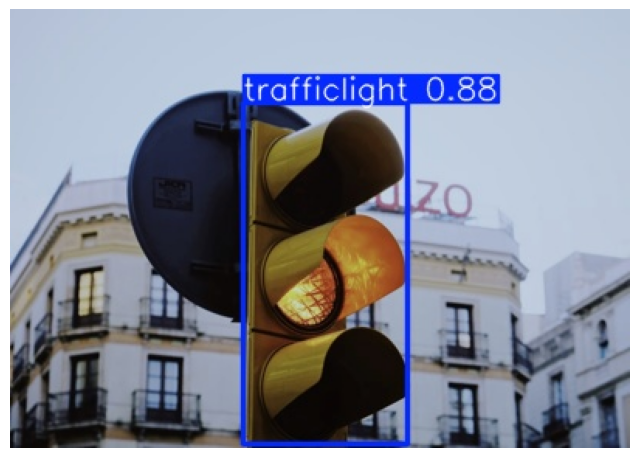

In [ ]:
import matplotlib.pyplot as plt
test_image = plt.imread('/content/runs/detect/predict2/road1.jpg')

plt.figure(figsize=(8, 8))
plt.imshow(test_image)
plt.axis('off')
plt.show()

In [ ]:
model_Anchor_Box_Tuning=YOLO("yolov8n.pt")

In [ ]:
results = model_Anchor_Box_Tuning.train(
    data = '/content/working/yolov8/data/road_sign_data.yaml',
    epochs = 50,
    imgsz = 1280,
    batch = 16,
    augment=True
)

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/working/yolov8/data/road_sign_data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

train: Scanning /content/working/labels/train.cache... 701 images, 0 backgrounds, 0 corrupt: 100%|██████████| 701/701 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/working/labels/val.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.83G     0.7929       3.89      1.062         28       1280: 100%|██████████| 44/44 [00:51<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]

                   all         88        132    0.00542      0.911       0.65      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.59G     0.8068       2.74      1.056         39       1280: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all         88        132      0.666        0.5      0.589       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       9.6G     0.7998      2.377      1.049         32       1280: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]

                   all         88        132      0.835      0.688      0.812      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.61G     0.7936      2.094      1.038         56       1280: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all         88        132      0.752      0.619      0.702      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.61G     0.7474      1.685       1.03         35       1280: 100%|██████████| 44/44 [00:44<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

                   all         88        132      0.907      0.772      0.857       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.61G     0.7694      1.447      1.018         33       1280: 100%|██████████| 44/44 [00:43<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all         88        132      0.884      0.759      0.848      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.61G     0.7427      1.256       1.01         29       1280: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]

                   all         88        132      0.754      0.793       0.82      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.61G     0.7526       1.17      1.024         31       1280: 100%|██████████| 44/44 [00:43<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all         88        132      0.883      0.811      0.873      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      9.61G     0.7348      1.065      1.007         34       1280: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all         88        132       0.91      0.861      0.899      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.61G     0.7315     0.9441     0.9986         34       1280: 100%|██████████| 44/44 [00:45<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         88        132      0.876      0.854      0.913      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.61G     0.6966     0.8266     0.9827         23       1280: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         88        132      0.947      0.865      0.921      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.61G     0.6808     0.7855     0.9853         32       1280: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         88        132      0.946      0.858      0.903      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.61G     0.6646      0.744     0.9698         50       1280: 100%|██████████| 44/44 [00:46<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all         88        132      0.871      0.884      0.878      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.61G     0.6415     0.6787     0.9696         31       1280: 100%|██████████| 44/44 [00:45<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all         88        132      0.906      0.878      0.889      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.61G     0.6418     0.6532     0.9558         36       1280: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all         88        132      0.938      0.892      0.923      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.62G     0.6356     0.6517     0.9546         23       1280: 100%|██████████| 44/44 [00:46<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

                   all         88        132      0.938      0.903      0.923      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.64G     0.6386      0.643     0.9601         26       1280: 100%|██████████| 44/44 [00:46<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all         88        132      0.939        0.9      0.918      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.64G     0.6253     0.5853     0.9519         27       1280: 100%|██████████| 44/44 [00:47<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         88        132      0.957      0.895      0.919      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.64G     0.6354     0.5764     0.9613         24       1280: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all         88        132      0.969       0.89      0.932      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.64G     0.6196     0.5458      0.943         34       1280: 100%|██████████| 44/44 [00:47<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         88        132      0.904      0.866       0.88      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.64G     0.6277     0.5446     0.9524         36       1280: 100%|██████████| 44/44 [00:44<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]

                   all         88        132      0.988      0.894      0.936      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.65G     0.6132     0.5272     0.9437         18       1280: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         88        132      0.962      0.869      0.926      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.65G     0.5849     0.4992     0.9247         40       1280: 100%|██████████| 44/44 [00:45<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all         88        132      0.953      0.852      0.896      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.65G     0.6212     0.4845     0.9373         31       1280: 100%|██████████| 44/44 [00:46<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all         88        132      0.919       0.89      0.905      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.66G     0.6043     0.4833     0.9421         39       1280: 100%|██████████| 44/44 [00:44<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]

                   all         88        132      0.935      0.902      0.915      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.67G     0.5825     0.4507     0.9313         38       1280: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all         88        132       0.92      0.895      0.898      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.67G     0.6091     0.4745     0.9429         29       1280: 100%|██████████| 44/44 [00:46<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         88        132      0.907      0.919      0.928      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.67G     0.5952     0.4546     0.9284         36       1280: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

                   all         88        132      0.937      0.896      0.929       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.67G     0.5777     0.4408     0.9223         32       1280: 100%|██████████| 44/44 [00:48<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all         88        132       0.94      0.885      0.907      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.67G     0.5584      0.424     0.9164         27       1280: 100%|██████████| 44/44 [00:45<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]

                   all         88        132      0.977      0.882      0.922       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.69G     0.5647     0.4271     0.9134         28       1280: 100%|██████████| 44/44 [00:46<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         88        132      0.955      0.934      0.943      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      9.71G     0.5692     0.4225     0.9257         36       1280: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

                   all         88        132      0.968      0.903      0.951      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.71G     0.5371     0.4126     0.9187         25       1280: 100%|██████████| 44/44 [00:46<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all         88        132      0.968       0.87      0.916      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.71G     0.5532     0.4009     0.9259         22       1280: 100%|██████████| 44/44 [00:46<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         88        132      0.975      0.904      0.929      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      9.72G     0.5378      0.386      0.911         37       1280: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         88        132      0.925      0.893      0.915      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.72G     0.5309      0.381     0.9002         36       1280: 100%|██████████| 44/44 [00:44<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all         88        132      0.988      0.875      0.915       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.72G      0.518     0.3704     0.8988         44       1280: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all         88        132       0.99      0.877      0.916       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.72G     0.5328     0.3961     0.9057         28       1280: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all         88        132      0.988      0.894      0.935      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.72G     0.5198     0.3754     0.8935         35       1280: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]

                   all         88        132      0.931      0.892      0.919      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.72G     0.5055     0.3523     0.8956         30       1280: 100%|██████████| 44/44 [00:45<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]

                   all         88        132      0.983      0.888      0.945      0.789


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.72G     0.5004     0.3442     0.8715         21       1280: 100%|██████████| 44/44 [00:56<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

                   all         88        132      0.925      0.909      0.924      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.72G     0.4918     0.3289     0.8651         14       1280: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]

                   all         88        132      0.936      0.898      0.928      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.72G     0.4861     0.3241     0.8668         19       1280: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         88        132      0.942      0.883      0.921      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.72G     0.4883     0.3183     0.8722         27       1280: 100%|██████████| 44/44 [00:43<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

                   all         88        132      0.964      0.883      0.907      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.72G     0.4854     0.3161     0.8694         22       1280: 100%|██████████| 44/44 [00:46<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all         88        132      0.958      0.883      0.918      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.72G     0.4786     0.3045      0.857         16       1280: 100%|██████████| 44/44 [00:44<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         88        132      0.936      0.896      0.925      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.72G     0.4648     0.3037     0.8597         21       1280: 100%|██████████| 44/44 [00:44<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]

                   all         88        132      0.958      0.907      0.928      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.72G      0.469     0.2971     0.8597         18       1280: 100%|██████████| 44/44 [00:44<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all         88        132      0.938      0.909      0.934      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.72G     0.4644     0.2876     0.8629         23       1280: 100%|██████████| 44/44 [00:43<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         88        132      0.967      0.907      0.942      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.72G     0.4611     0.2861     0.8586         20       1280: 100%|██████████| 44/44 [00:46<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]

                   all         88        132      0.953      0.906      0.941      0.793



50 epochs completed in 0.686 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.4MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.4MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.96s/it]

In [ ]:
from ultralytics import YOLO
model = YOLO("./runs/detect/train/weights/best.pt")

##Testing on Video & Image Sequences
Running YOLO on a Video

In [ ]:
results=model.predict("GX011158.MP4", save=True)

###Saving Frames with High Confidence
Filtered out low-confidence predictions (conf > 0.5).

In [ ]:
import cv2

video_path = "GX011162.MP4"
output_path = "output_video.mp4"

cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define VideoWriter to save output video
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

while cap.isOpened():
	ret, frame = cap.read()
	if not ret:
		break

	# Run YOLO on the frame
	results = model(frame)
	result = results[0]

	# Filter detections with confidence > 0.5
	for box in result.boxes:
		if box.conf > 0.5:
			frame = result.plot()  # Draw bounding boxes

	out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()
print("Video saved at:", output_path)


0: 736x1280 2 trafficlights, 289.6ms
Speed: 27.1ms preprocess, 289.6ms inference, 14.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 trafficlight, 1 speedlimit, 175.4ms
Speed: 18.4ms preprocess, 175.4ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 trafficlight, 188.4ms
Speed: 15.3ms preprocess, 188.4ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 crosswalk, 212.2ms
Speed: 18.2ms preprocess, 212.2ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 trafficlight, 198.6ms
Speed: 10.6ms preprocess, 198.6ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 189.0ms
Speed: 13.6ms preprocess, 189.0ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 trafficlight, 1 crosswalk, 176.0ms
Speed: 13.8ms preprocess, 176.0ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1

# Suggestions for Improving Small Object Detection  

🔹 **Use YOLOv8m or YOLOv8l:** Larger models detect small objects better.  
🔹 **Super-Resolution Preprocessing:** Use ESRGAN to upscale images.  
🔹 **Fine-Tune Focal Loss:** Helps detect rare objects better.  
🔹 **Adjust Image Size Dynamically:** Use `imgsz=1536` for best results.  
🔹 **Train with Class Balancing:** Prevent bias towards frequently appearing objects.  
